# Example: Fitting your own waveform

In [1]:
from jaxqualin.waveforms import delayed_QNM, waveform
from jaxqualin.qnmode import mode, mode_list
from jaxqualin.fit import QNMFitVaryingStartingTime
from jaxqualin.selection import ModeSearchAllFreeVaryingN
from jaxqualin.plot import (plot_amplitudes, plot_phases, 
                            plot_omega_free, plot_predicted_qnms,
                            plot_mode_searcher_results)

import numpy as np
import matplotlib.pyplot as plt

### Make waveform

As example, we will make a waveform that contains three QNMs that are distorted close to the merger peak. 
You can replace this with whatever time domain waveform you would like to fit.

In [2]:
Mf = 1
af = 0.7
modes = mode_list(['2.2.0', '2.2.1', '3.2.0'], Mf, af)
A_phi_dict = {'2.2.0': dict(A = 1., phi = 0.),
              '2.2.1': dict(A = 3., phi = np.pi/2),
              '3.2.0': dict(A = 1e-2, phi = np.pi)}

t_arr = np.linspace(0, 120, 1000)
h_arr = np.zeros(t_arr.shape, dtype = np.complex128)
for i, mode in enumerate(modes):
    if i == 0:
        A_delay = 0
        A_sig = 10
        phi_sig = 5
    else:
        A_delay = 5
        A_sig = 2
        phi_sig = 2
    h_arr += delayed_QNM(mode, t_arr, 
                         A_phi_dict[mode.string()]['A'], 
                         A_phi_dict[mode.string()]['phi'],
                         A_delay = A_delay, A_sig = A_sig, phi_sig = phi_sig)

### Make waveform object

You can pass in whatever time domain waveform. 
If you know that the peak strain is located at t = 0, then pass in `t_peak = 0`, or else the waveform object detects the peak on its own.
If `t_peak` is not passed, the first `remove_num = 500` data points are removed by default because BBH merger simulations often contain junk radiation in the beginning.
You can set `remove_num = 0` if you do not want to remove any data points.

In [3]:
h = waveform(t_arr, h_arr, t_peak = 0)

Text(0, 0.5, '$|h_r|$')

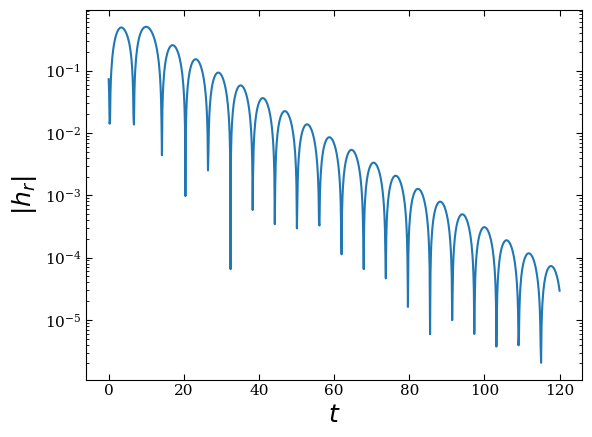

In [4]:
fig, ax = plt.subplots()
ax.semilogy(h.time, np.abs(h.hr))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$|h_r|$')

### Free QNMs (unfixed frequencies)

In [5]:
t0_arr = np.linspace(0, 50, num = 101) # array of starting times to fit for
                                       # t0 = 0 is the peak of the strain
qnm_fixed_list = [] # list of QNMs with fixed frequencies in the fit model
run_string_prefix = f"custom_example_lm_2.2" # prefix of pickle file for saving the results
N_free = 3 # number of free modes to use

# fitter object
fitter = QNMFitVaryingStartingTime(
                            h, t0_arr, N_free = N_free,
                            qnm_fixed_list = qnm_fixed_list, load_pickle = True,
                            run_string_prefix = run_string_prefix)

In [6]:
# do fits, in series from lowest to highest starting time
# This takes a little longer to run the first time
fitter.do_fits()

Loaded fit custom_example_lm_2.2_N_3_t0_0.0000_50.0000_101 from an old run.


In [7]:
# fitter results object
result = fitter.result_full

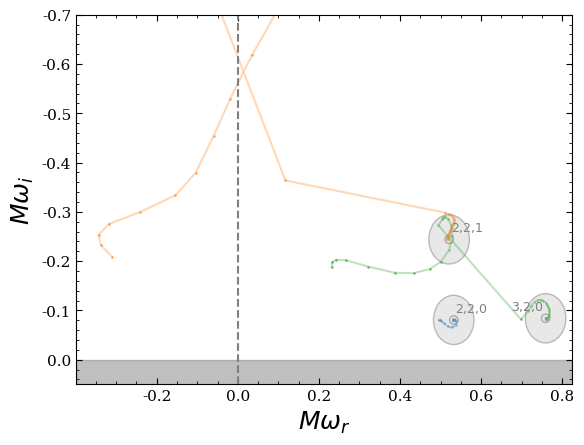

In [8]:
fig, ax = plt.subplots()

# mode locations to visualize on the plot
predicted_qnms = mode_list(['2.2.0', '2.2.1', '3.2.0'], Mf, af)

plot_omega_free(result, ax)
plot_predicted_qnms(ax, predicted_qnms)

### Fixed QNMs (fixed frequencies)

In [9]:
t0_arr = np.linspace(0, 50, num = 101) # array of starting times to fit for
                                       # t0 = 0 is the peak of the straisn
qnm_fixed_list = mode_list(['2.2.0', '2.2.1', '3.2.0'],
                                   Mf, af) # list of QNMs with fixed frequencies in the fit model
run_string_prefix = f"custom_example_lm_2.2" # prefix of pickle file for saving the results
N_free = 0 # number of free modes to use

# fitter object
fitter = QNMFitVaryingStartingTime(
                            h, t0_arr, N_free = N_free,
                            qnm_fixed_list = qnm_fixed_list, load_pickle = True,
                            run_string_prefix = run_string_prefix)

In [10]:
fitter.do_fits()
result = fitter.result_full

Loaded fit custom_example_lm_2.2_N_0_fix_2.2.0_2.2.1_3.2.0_t0_0.0000_50.0000_101 from an old run.


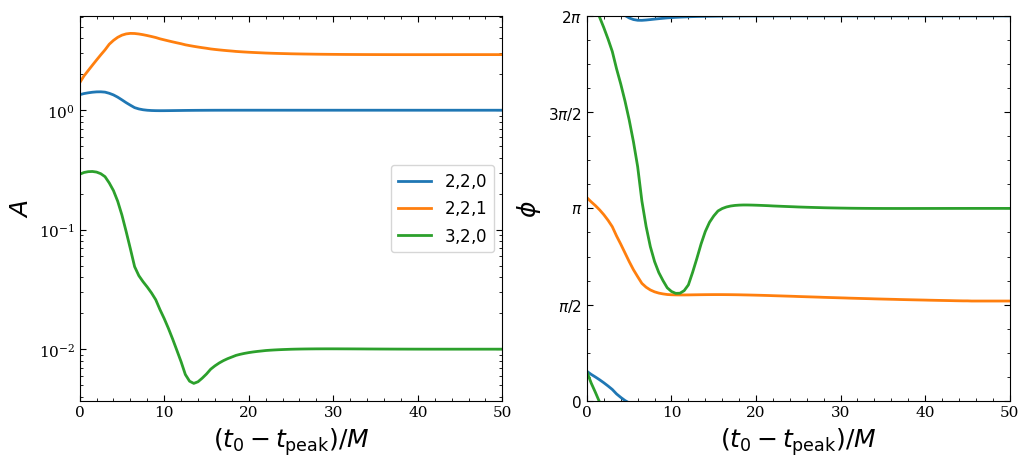

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
plot_amplitudes(result, fixed_modes = qnm_fixed_list, ax = axs[0])
plot_phases(result, fixed_modes = qnm_fixed_list, ax = axs[1], legend = False)

### Mode search

With `BBH_potential_modes = True` (default), the mode searcher uses a list of modes that are expected to be seen in the waveform in a binary-black-hole merger, which depends on the waveform harmonic in question. For a custom waveform, the harmonic can be specified by `h.set_lm(l, m)`. The modesearcher will include all the overtones in that harmonic, spheroidal mixing modes with the same `m` but another `l`, and quadratic modes with `m_1 + m_2 = m`. mode mixing from other harmonics (e.g. due to not working in the superrest BMS frame) can be included by specifying `relevant_lm_list`. Consult the source code of the `potential_modes` function in `jaxqualin.qnmode` for more details.

Additional custom modes can be included with the `potential_modes_custom` keyword argument. If `BBH_potential_modes = False` then these will be the only potential modes that the mode searcher will try to find.

In [12]:
h.set_lm(2, 2)
relevant_lm_list = [(2,2)]
potential_modes_custom = qnm_fixed_list = mode_list(['-2.2.0x2.2.0'], Mf, af)
run_string_prefix = f"custom_example_lm_2.2" # prefix of pickle file for saving the results
mode_searcher = ModeSearchAllFreeVaryingN(h, Mf, af, 
                                          relevant_lm_list = relevant_lm_list,
                                          N_list = [3], 
                                          t0_arr = t0_arr,
                                          run_string_prefix = run_string_prefix,
                                          BBH_potential_modes = True,
                                          potential_modes_custom = potential_modes_custom
                                        )


In [13]:
mode_searcher.do_mode_searches()

Loaded fit custom_example_lm_2.2_N_3_t0_0.0000_50.0000_101 from an old run.
Runname: custom_example_lm_2.2, N_free = 3, potential modes: 2.2.1, 3.2.0, 2.2.0
Performing amplitude and phase flatness check for N_free = 3
Loaded fit custom_example_lm_2.2_N_0_fix_2.2.0_2.2.1_3.2.0_t0_0.0000_50.0000_101 from an old run.
Runname: custom_example_lm_2.2, N_free = 3, found the following 3 modes: 
2.2.1, 3.2.0, 2.2.0


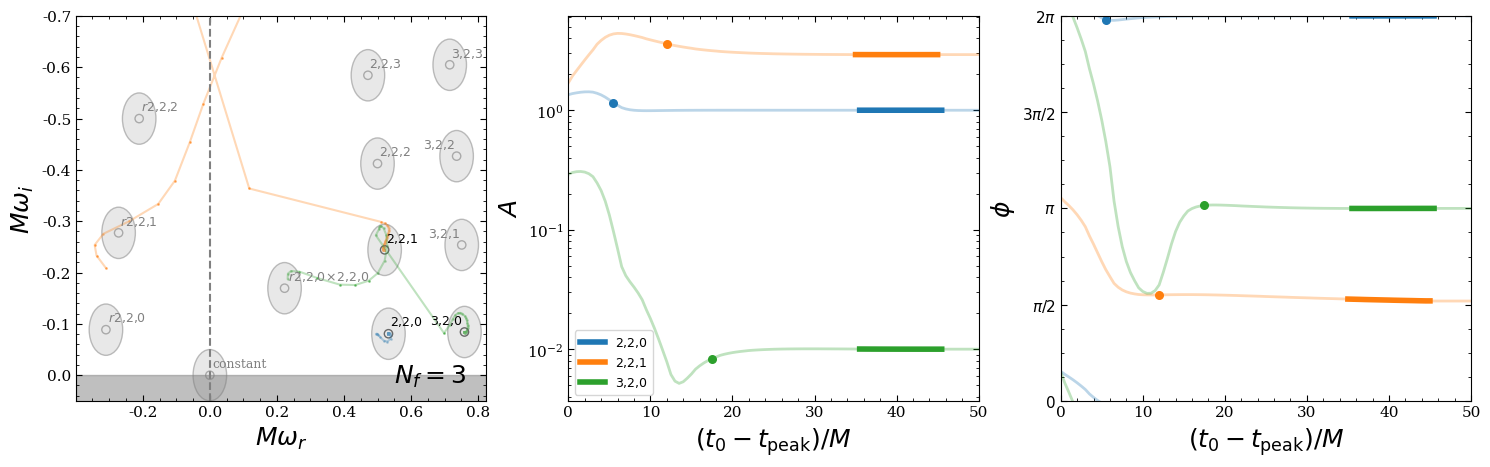

In [14]:
plot_mode_searcher_results(mode_searcher)